In [15]:
assay_index = 28

In [16]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
/ [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


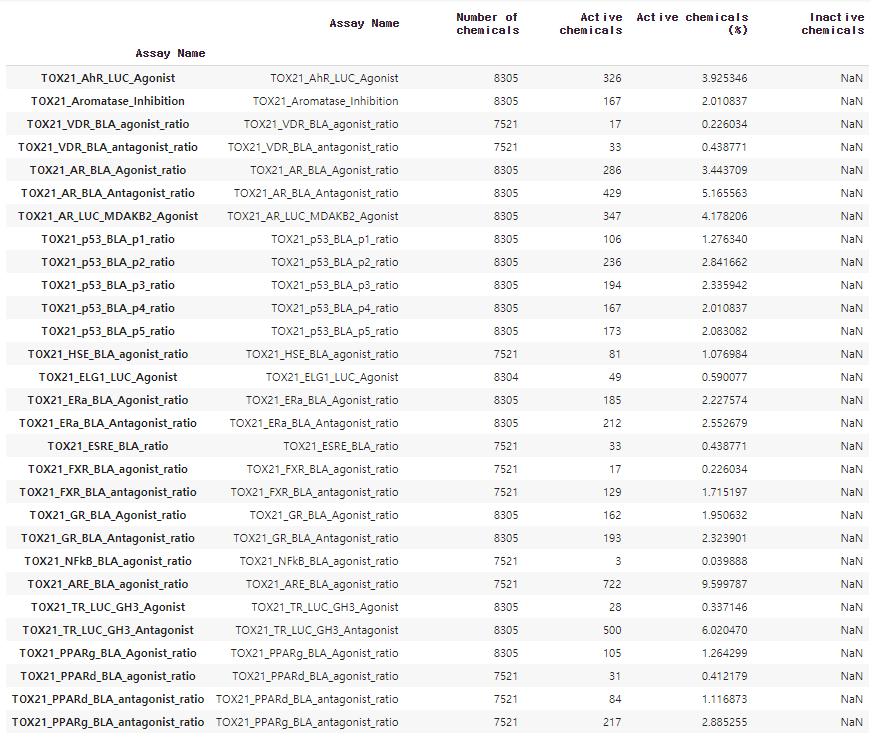

In [17]:
selected_assay_list = ['TOX21_AhR_LUC_Agonist', 'TOX21_Aromatase_Inhibition', 'TOX21_VDR_BLA_agonist_ratio', 'TOX21_VDR_BLA_antagonist_ratio', 'TOX21_AR_BLA_Agonist_ratio', 'TOX21_AR_BLA_Antagonist_ratio', 'TOX21_AR_LUC_MDAKB2_Agonist', 'TOX21_p53_BLA_p1_ratio', 'TOX21_p53_BLA_p2_ratio', 'TOX21_p53_BLA_p3_ratio', 'TOX21_p53_BLA_p4_ratio', 'TOX21_p53_BLA_p5_ratio', 'TOX21_HSE_BLA_agonist_ratio', 'TOX21_ELG1_LUC_Agonist', 'TOX21_ERa_BLA_Agonist_ratio', 'TOX21_ERa_BLA_Antagonist_ratio', 'TOX21_ESRE_BLA_ratio', 'TOX21_FXR_BLA_agonist_ratio', 'TOX21_FXR_BLA_antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio', 'TOX21_GR_BLA_Antagonist_ratio', 'TOX21_NFkB_BLA_agonist_ratio', 'TOX21_ARE_BLA_agonist_ratio', 'TOX21_TR_LUC_GH3_Agonist', 'TOX21_TR_LUC_GH3_Antagonist', 'TOX21_PPARg_BLA_Agonist_ratio', 'TOX21_PPARd_BLA_agonist_ratio', 'TOX21_PPARd_BLA_antagonist_ratio', 'TOX21_PPARg_BLA_antagonist_ratio']

In [18]:
selected_assay_list.remove('TOX21_NFkB_BLA_agonist_ratio') #active물질 개수가 3개뿐인 assay라 모델 

In [19]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [20]:
df

,Unnamed: 0,TOX21_AhR_LUC_Agonist,smiles,TOX21_Aromatase_Inhibition,TOX21_VDR_BLA_agonist_ratio,TOX21_VDR_BLA_antagonist_ratio,ATG_Ahr_CIS_up,NVS_ADME_hCYP2C19,NVS_ADME_hCYP19A1,NVS_ADME_hCYP2C9,NVS_ADME_hCYP1A1,NVS_ADME_hCYP1A2,NVS_ADME_hCYP3A4,NVS_ADME_hCYP2B6,NVS_ADME_hCYP2D6,NVS_ADME_hCYP2A6,NVS_ADME_hCYP4F12,NVS_ADME_rCYP2C12,TOX21_AR_BLA_Agonist_ratio,TOX21_AR_BLA_Antagonist_ratio,TOX21_AR_LUC_MDAKB2_Agonist,ATG_AR_TRANS_up,OT_AR_ARELUC_AG_1440,OT_AR_ARSRC1_0480,OT_AR_ARSRC1_0960,NVS_NR_rAR,NVS_NR_hAR,TOX21_p53_BLA_p1_ratio,TOX21_p53_BLA_p2_ratio,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p5_ratio,TOX21_HSE_BLA_agonist_ratio,TOX21_ELG1_LUC_Agonist,ATG_p53_CIS_up,ATG_E2F_CIS_up,ATG_HSE_CIS_up,ATG_Myb_CIS_up,ATG_Myc_CIS_up,BSK_BE3C_uPA_down,...,NVS_GPCR_rAdra1B,NVS_GPCR_r5HT_NonSelective,NVS_GPCR_r5HT1_NonSelective,NVS_GPCR_hAdra2A,NVS_GPCR_hH1,NVS_ENZ_hPTPN11,NVS_GPCR_hAdoRA2a,NVS_GPCR_hAdrb3,NVS_GPCR_rNK3,NVS_LGIC_rNNR_BungSens,NVS_GPCR_hM1,NVS_ENZ_hPDE10,NVS_ENZ_hPTPN12,NVS_GPCR_rAdra2_NonSelective,NVS_GPCR_hAdrb2,NVS_GPCR_hDRD4.4,NVS_TR_rNET,NVS_TR_hAdoT,NVS_ENZ_hPTPN13,NVS_GPCR_rSST,NVS_GPCR_hLTB4_BLT1,NVS_GPCR_hAT1,NVS_LGIC_bGABARa1,NVS_LGIC_h5HT3,NVS_GPCR_rAdrb_NonSelective,NVS_ENZ_hTrkA,NVS_LGIC_rGABAR_NonSelective,NVS_GPCR_bDR_NonSelective,NVS_GPCR_rV1,NVS_LGIC_hNNR_NBungSens,TOX21_PPARg_BLA_Agonist_ratio,TOX21_PPARd_BLA_agonist_ratio,TOX21_PPARd_BLA_antagonist_ratio,TOX21_PPARg_BLA_antagonist_ratio,ATG_PPARa_TRANS_up,ATG_PPRE_CIS_up,ATG_PPARd_TRANS_up,ATG_PPARg_TRANS_up,NVS_NR_hPPARg,NVS_NR_hPPARa
0,100-00-5,N,[O-][N+](=O)C1=CC=C(Cl)C=C1,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
1,1000-05-1,N,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
2,10001-13-5,N,CN1CCN(CC1)C(=O)C1CCCCC1,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN
3,100-01-6,N,NC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,6.449239794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.086069804,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
4,100-02-7,N,OC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,0.000103442,N,0.000122936,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9219,NOCAS_903892,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN
9220,NOCAS_903893,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [21]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

IndexError: ignored

In [ ]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

In [ ]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

In [ ]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [ ]:
assays_ss = df_ss.columns

In [ ]:
assays_ss

In [ ]:
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42,sampling_strategy = "minority")

In [ ]:
ss

In [ ]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

In [ ]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [ ]:
d

In [ ]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [ ]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [ ]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


In [ ]:
dups_list = list(set(listofdups))

In [ ]:
dups_list # 0인것만 지우는게 맞나?

In [ ]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [ ]:
train = train.drop(dups_list_0)

In [ ]:
train

In [ ]:
len(smiles_list)

In [ ]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

In [ ]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/29assays_dd/'

In [ ]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

In [ ]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [ ]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

In [ ]:
err_smiles_df

In [ ]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label', fix_imbalance = True, fix_imbalance_method = sme
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

# RF - default parameter

In [ ]:
save_path_m = save_path+'/rf/'

In [ ]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

In [ ]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

In [ ]:
plot_model(rf, plot = 'auc')

In [ ]:
plot_model(rf, plot = 'pr')

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
print(rf)

# RF - tuned parameter by AUC

In [ ]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

In [ ]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

# RF -tuned parameter by F1

In [ ]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

In [ ]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

# RF -tuned parameter by Kappa

In [ ]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

In [ ]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

# RF -tuned parameter by MCC

In [ ]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

In [ ]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

In [ ]:
plot_model(tuned_rf_auc, plot = 'auc')

In [ ]:
plot_model(tuned_rf_auc, plot = 'pr')

In [ ]:
plot_model(tuned_rf_auc, plot='feature')

In [ ]:
print(tuned_rf_auc)

In [ ]:
plot_model(tuned_rf_f1, plot = 'auc')

In [ ]:
plot_model(tuned_rf_f1, plot = 'pr')

In [ ]:
plot_model(tuned_rf_f1, plot='feature')

In [ ]:
print(tuned_rf_f1)

In [ ]:
plot_model(tuned_rf_kappa, plot = 'auc')

In [ ]:
plot_model(tuned_rf_kappa, plot = 'pr')

In [ ]:
plot_model(tuned_rf_kappa, plot='feature')

In [ ]:
print(tuned_rf_kappa)

In [ ]:
plot_model(tuned_rf_MCC, plot = 'auc')

In [ ]:
plot_model(tuned_rf_MCC, plot = 'pr')

In [ ]:
plot_model(tuned_rf_MCC, plot='feature')

In [ ]:
print(tuned_rf_MCC)

# all algorithm compare with validation auc

In [ ]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path